# Research
***
[Alejandro Ciuba](alejandrociuba.github.io), alc307@pitt.edu
***
## Summary
This is a continuation from the previous Jupyter Notebook (`overview.ipynb`) where I begin to analyze the data in-accordance to my proposed research questions. I might change or modify the research questions here. As such, I update both this and the main `README.md` file (not in `project_plan.md`, to retain the initial ideas for this research).
***
## Table of Contents
1. [Python Set-Up](#python-set-up)
2. [Orders & Requests](#how-are-ordersrequests-realized-in-video-game-dialogue)
3. [2nd Person Singular](#exploring-usage-of-the-2nd-person-pronoun)
4. [Other Pronouns](#other-pronouns)
5. [Entities](#named-entities)
6. [Hapaxes](#hapaxes)
***
## Python Set-Up

In [2]:
# Necessary imports
import nltk
import spacy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import pickle as pkl

### Settings

In [3]:
# Settings
# I looked this up so everything is prettier
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Use display(dataframe) to show

%pprint

Pretty printing has been turned OFF


### Useful Functions

In [4]:
# Useful functions
# Makes a boxplot with my overall preferred settings
def barplot(x:list=[], y:list=[], title:str='NO TITLE', xlabel:str='x', ylabel:str='y', xtickrot:float=0.0):

    ax = sns.barplot(x=x, y=y)
    sns.set_style(style='dark')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xtickrot)
    plt.bar_label(ax.containers[0])    

# Function such that it counts all instances of the given regular expression for each item in a dataframe's specified column
def locator(series: pd.Series, regex:re.Pattern) -> int:
    return np.sum([len(x) for x in series.str.findall(regex)])

# Now, let's normalize these by getting them as percentages, 
def get_count(col:pd.Series) -> int:
    count = 0
    for text in col:
        count += len(nltk.word_tokenize(text))
    return count

# Generator which yields the concordances for a given textual column of a dataframe
# phrase should be a raw string, context cols should be a list of column names
# once_per = only one concordance per textual datapoint (if there is more)
# sides = # of chars to the left and right
# num = number of concordances to display
# Assumes properly formatted text
def concordances(df:pd.DataFrame, phrase:str, col:str='text', context_cols: list()=[], sides:int=7, num:int=20, once_per=False):
    
    # Set-up
    context = bool(len(context_cols))
    regex = r'((?:[\S]+ ){,' + str(sides) + r'})(\b' + phrase + r'\b)((?:[\S]+)?(?: [\S]+){,' + str(sides) + r'})'
    cutoff = 0

    for (ind, concordance_list) in enumerate(df[col].str.findall(regex, re.I)):

        if len(concordance_list) == 0:
            continue

        # Format text if context was stated
        output = ''
        if context:
            cont = df.loc[ind, context_cols]
            output = ' | '.join([col.title() + ": " + cont[col] for col in context_cols]) + " | Concordance:\n\t"

        for concordance in concordance_list:
            cutoff += 1
            if cutoff > num:
                return
            else:
                concordance = list(concordance)
                concordance[1] = concordance[1].upper() # Do it separately due to edge case "your you" -> "YOUr YOU"
                yield output + '...' + ''.join(concordance) + '...'
            if once_per:
                break

### Data-Importing

In [5]:
# Bringing in the dataframes
FILEPATH = "../private/pickled_dfs/"

elder_scrolls_df = pd.read_pickle(FILEPATH + "elder_scrolls.pkl")
hollow_knight_df = pd.read_pickle(FILEPATH + "hollow_knight.pkl")
kotor_df = pd.read_pickle(FILEPATH + "kotor.pkl")
torchlight_df = pd.read_pickle(FILEPATH + "torchlight.pkl")

# All dfs stored in a simple list
datasets = [elder_scrolls_df, hollow_knight_df, kotor_df, torchlight_df]

### spaCy Set-Up

In [6]:
# Load the standard en_core_web small package pipeline (larger would be overkill for the task at hand)
nlp = spacy.load("en_core_web_trf")

In [7]:
# Create a stream dump of all the text from hollow_knight_df and torchlight_df, save them to two files in my private sub-directory
# Create random sample .txts from elder_scrolls_df and kotor_df, 1000000 is the max amount of tokens
# MADE FALSE TO PREVENT ACCIDENTAL FILE CREATION
if False:
    with open('../private/text_dumps/hollow_knight.txt', 'w') as src:
        for text in hollow_knight_df['text']:
            src.write(text)

    with open('../private/text_dumps/torchlight.txt', 'w') as src:
        for text in torchlight_df['text']:
            src.write(text)

    with open('../private/text_dumps/elder_scrolls_samp.txt', 'w') as src:
        for text in elder_scrolls_df['text'].sample(500):
            src.write(text)

    with open('../private/text_dumps/kotor_samp.txt', 'w') as src:
        for text in kotor_df['text'].sample(500):
            src.write(text)

In [8]:
# Create document objects from the texts
# MEMORY INTENSIVE!!!
if False:
    with open('../private/text_dumps/torchlight.txt', 'r') as src:
        torchlight_doc = nlp(src.read(-1))
    print(type(torchlight_doc), len(torchlight_doc))

    with open('../private/text_dumps/hollow_knight.txt', 'r') as src:
        hollow_knight_doc = nlp(src.read(-1))
    print(type(hollow_knight_doc), len(hollow_knight_doc))

    with open('../private/text_dumps/elder_scrolls_samp.txt', 'r') as src:
        elder_scrolls_doc = nlp(src.read(-1))
    print(type(elder_scrolls_doc), len(elder_scrolls_doc))

    with open('../private/text_dumps/kotor_samp.txt', 'r') as src:
        kotor_doc = nlp(src.read(-1))
    print(type(kotor_doc), len(kotor_doc))

    # A list of the docs, structured like the datasets list
    docs = [elder_scrolls_doc, hollow_knight_doc, kotor_doc, torchlight_doc]

In [9]:
# Let's pickle these for later use
if False:
    with open('../private/pickled_docs/docs.pkl', 'wb') as src:
        pkl.dump(docs, src, -1)

# Load the pickled list
if True:
    with open('../private/pickled_docs/docs.pkl', 'rb') as src:
        docs = pkl.load(src)
        elder_scrolls_doc = docs[0]
        hollow_knight_doc = docs[1]
        kotor_doc = docs[2]
        torchlight_doc = docs[3]

### Dictionary

In [10]:
data = {game: [df, doc] for (game, df, doc) in zip(["TES Books", "Hollow Knight", "KOTOR", "Torchlight II"], datasets, docs)}

***
## How Are Orders/Requests Realized in Video Game Dialogue?
This is a very broad topic. To approach this topic, let's first consider common phrases which indicate orders and requests.
- Direct Orders:
    1. _(Don't/Do not) mand. form X._
    2. _I order/demand/force (that) you X._ (Performative Speech Act)
- Indirect Orders:
    1. _You /need to/have to/must X._
    2. _Your objective/goal/quest/task is X._
    3. _X need/want/require (that)/desire that you Y._ 
    4. _Let's/Let us X._
- Direct Requests:
    1. _Please X._
    2. _I request (that you)/ask (of you) X._ (Performative Speech Act)
- Indirect Requests:
    1. _X would like (that) you Y._
    2. _May/Would/Can/Could you X?_
    3. _Is it possible to/that you X?_
    4. _Are you able to X?_

This is obviously not an exhastive list, but it does cover the most common forms that orders and requests can take.

### Approach
The way I will examine these previously mentioned requests and orders are as follows:
1. Condense as many as I can into regular expressions.
2. For those which I deem unsuitable for pure regular expressions, _spaCy_ will be used to provide additional context clues with its part of speech tagging ([est. 97% accuracy](https://spacy.io/usage/facts-figures#benchmarks)).

***
## Exploring Usage of the 2nd Person Pronoun
First, focusing on _you_ (not "you-you", but _you_, the word), let's simply graph the number of occurrences in each of the datasets. To do this, we must consider what forms of you could appear in the dataset. Obviously, the biggest concerns would be contractions (_you're_, _you'd_), but what about _y'all_? Since _y'all_ can refer **both** to an individual and a group of people, I chose to ignore it for two reasons:
1. I am want to focus on the 2nd person **singular** pronoun to see how it is used in relation to the player.
2. Overall occurrences of _y'all_ are low, and the times they refer directly to the player is even lower; this means we can ignore it without the concern of data-skewing.

Previously, I have created a function which, given a compiled regular expression, will find all instances of that regular expression for each textual item in a dataframe's column. And below, I have compiled a relatively simple regex to capture all the _you_ instances I am after. I then plot the number of _you_ occurrences for each dataset.

In [11]:
you_re = re.compile(r"\byou\b", re.IGNORECASE)

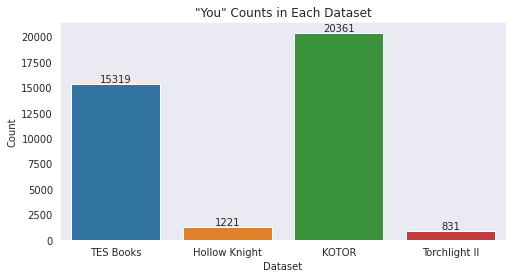

In [36]:
counts = np.array([])

for df in datasets:
    counts = np.append(counts, locator(df['text'], you_re))

plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=counts, title='"You" Counts in Each Dataset', xlabel="Dataset", ylabel="Count")
plt.show()

In [37]:
# Hollowknight suffers from some slight inaccuracies due to its tagging system
percentages = counts / [get_count(df['text']) for df in datasets]

print(percentages)

[0.00799316 0.02830189 0.03653764 0.02430749]


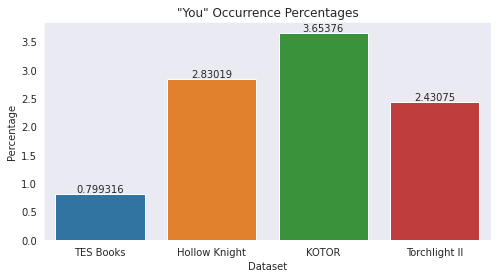

In [38]:
plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=percentages*100, title='"You" Occurrence Percentages', xlabel="Dataset", ylabel="Percentage")
plt.show()

This makes sense given that the data for _Hollow Knight_, _KOTOR_, and _Torchlight_ all relate to directing the player and giving the players objectives/quests in some way, shape, or form. The dataset pertaining to _The Elder Scrolls_ however, does not. Since its dataset is that of books written to be read by the player in-game, it makes sense that there is an extremely low frequency of the 2nd person pronoun. I expect this to change with other pronouns.

Let's take a look at some of the contexts which the second person singular takes place in.

In [32]:
print("===================== \"You\" Concordance Samples =====================")
print("===================== TES Books =====================")
for sent in concordances(elder_scrolls_df.sample(100, ignore_index=True), phrase='you', context_cols=['author', 'title'], num=10, once_per=True):
    print(sent)

print("===================== Hollow Knight Dialogue =====================")
for sent in concordances(hollow_knight_df.sample(10, ignore_index=True), phrase='you', context_cols=['character'], num=10, once_per=True):
    print(sent)

print("===================== KOTOR Dialogue =====================")
for sent in concordances(kotor_df.sample(100, ignore_index=True), phrase='you', context_cols=['speaker', 'listener'],num=10, once_per=True):
    print(sent)

print("===================== Torchlight Quests =====================")
for sent in concordances(torchlight_df.sample(100, ignore_index=True), phrase='you', context_cols=['speaker'], num=10, once_per=True):
    print(sent)

===================== "You" Concordance Samples =====================
===================== TES Books =====================
Author: Lady Anais Velmont | Title: travel-itinerary | Concordance:
	...14: Set sail for Abah's Landing. See YOU when we get back!...
Author: Amun-dro | Title: dark-spirits | Concordance:
	...aloud is to invite the Dark, so YOU must never do so, as Namiira is...
Author: Aramril | Title: apprentices-assistant-0 | Concordance:
	...No doubt YOU have heard tales of my adventures. Stories...
Author: Quintus Navale | Title: letter-quintus-navale | Concordance:
	...Please come see me as soon as YOU can....
Author: Lod | Title: private-letter | Concordance:
	...Need all the iron ore YOU can dig up. Double my usual order....
Author: Cirantille | Title: care-kwama | Concordance:
	...evolve into the mine's protectors and soon YOU have nothing but the violent creatures to...
Author: Anonymous | Title: immortal-blood | Concordance:
	...my quizzical look. "I was told that YOU w

***
## Other Pronouns
Let's at the percentages for some other common pronouns: _I/me_, _he/she/him/her_, _we/us_, _they/them_. The reason I chose to go with these forms is because these forms can appear in the same contexts that _you_ would appear in. In other words, I'm simply leaving out posessive pronouns. Of course, just like with _you_, I have to consider some contractions, but those have been treated the same way as before.

In [39]:
# List of regexes
fp_re = re.compile(r"\b(?:I|me)\b") # Had to ignore case for this one
tp_re = re.compile(r"\b(?:(?:s)?he|(?:h)(?:er|im))\b", re.IGNORECASE)
fpp_re = re.compile(r"\b(?:we|us)\b", re.IGNORECASE)
tpp_re = re.compile(r"\bthe(?:y|m)\b", re.IGNORECASE)

re_dict = {"First Person Singular": fp_re, "Third Person Singular": tp_re, "First Person Plural": fpp_re, "Third Person Plural": tpp_re}

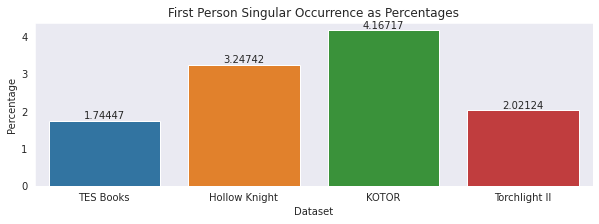

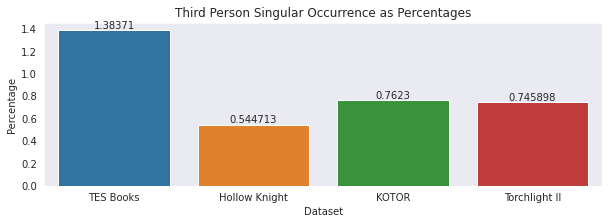

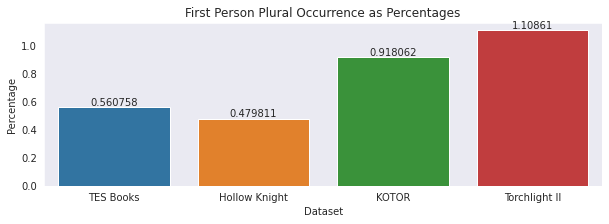

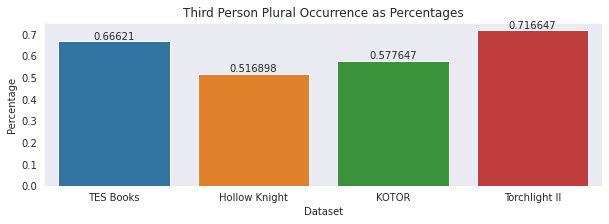

In [40]:
# Loop through everything
for pronoun in re_dict.keys():

    percentages = np.array([])

    plt.figure(figsize=(10, 3))

    for df in datasets:
        percentages = np.append(percentages, locator(df['text'], re_dict[pronoun])/get_count(df['text']))

    barplot(x=list(data.keys()), y=percentages*100, title=pronoun + ' Occurrence as Percentages', xlabel="Dataset", ylabel="Percentage")

plt.show()

***
## Named Entities
For this, I will be using _spaCy_ and its standard _"en\_core\_web\_sm"_ model. While it is an AI model, its named-entity tagger accuracy is [estimated to be around 89%](https://spacy.io/usage/facts-figures#benchmarks). I will also be taking only samples of `kotor_df` and `elder_scrolls_df` as their full texts are too big to be loaded onto one _spaCy_ model. Additionally, these models will base themselves off of the pure text of the dataframes, with no additional information. This is because, due to the fact I will be relying on named entity recognition, other data (author, character, listener, etc.) might (will) be mistaken as a named entity in the sentences. Furthermore, I am only interested in the named entities in the texts themselves, not outside sources.

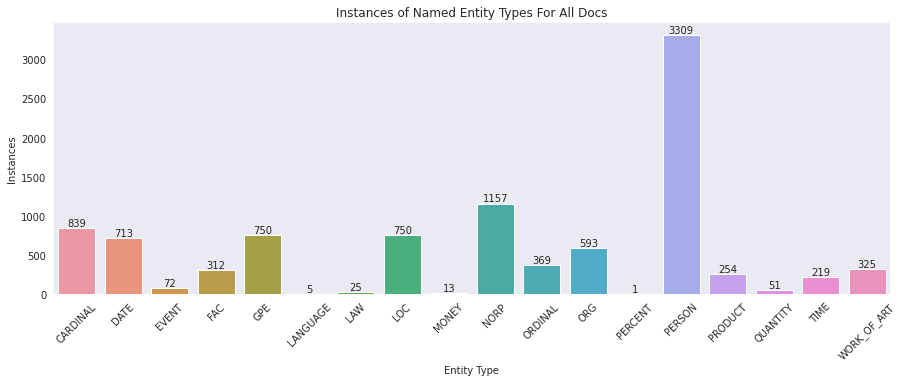

In [41]:
# Let's create a dictionary to keep track of the named-entity types we see
entities = {label: 0 for label in nlp.get_pipe('ner').labels}

for doc in docs:
    for ent in doc.ents:
        entities[ent.label_] += 1

plt.figure(figsize=(15,5))
barplot(x=list(entities.keys()), y=list(entities.values()), title="Instances of Named Entity Types For All Docs", xlabel="Entity Type", ylabel="Instances", xtickrot=45)

Let's create a dataframe which will contain the following information:

| Column | Data |
| ------ | ---- |
| `entity` | Name of the entity |
| `tag` | Entity Tag as given by _spaCy_ |
| `source` | Game from which it came |

This will be useful for graphing more detailed charts as well as exploring hapaxes.

In [42]:
# Dataframe creation
entities_df = pd.DataFrame({'entity':[], 'tag': [], 'source': []})
names = ['TES Books', 'Hollow Knight', 'KOTOR', 'Torchlight II']

# Loop through all the documents
for (doc, name) in zip(docs, names):
    for ent in doc.ents:
        entities_df = entities_df.append({'entity': ent.text, 'tag': ent.label_, 'source': name}, ignore_index=True)

In [43]:
print(entities_df.info())
display(entities_df.sample(10))
if False: entities_df.to_pickle('../sample_data/entities.pkl') # Save a .pkl for others to use

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9757 entries, 0 to 9756
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   entity  9757 non-null   object
 1   tag     9757 non-null   object
 2   source  9757 non-null   object
dtypes: object(3)
memory usage: 228.8+ KB
None


,entity,tag,source
1762,Broggo,PERSON,TES Books
8533,Zeraphi,NORP,Torchlight II
9499,the Frosted Hills,LOC,Torchlight II
4878,the Daggerfall Covenant,ORG,TES Books
2291,Ashlanders,NORP,TES Books
9690,Cacklespit,PERSON,Torchlight II
8263,the Sisters three,ORG,Torchlight II
5954,Velothi,NORP,TES Books
9190,Ordrak's Heart,PERSON,Torchlight II
2196,Oblivion,LOC,TES Books


Something interesting to note is that it lumps holidays/festivals (_Witches' Festival_, _Jester's Day_, etc.) into `ORG` (organizations) and [there is not a specific tag for holidays/festivals](https://spacy.io/api/annotation). There's also some mistakes (_Day_ being called a `PERSON`). But I will assume the errors are small and continue.

In [44]:
# Graph entities by type and game
# Creat stacked Series
entities_info = entities_df.groupby('tag').source.value_counts() # Never understood why this is a Series.

# Replace 'NaN's with 0
display(entities_info.unstack(fill_value=0)) # Wow

source,Hollow Knight,KOTOR,TES Books,Torchlight II
tag,,,,
CARDINAL,136,10,627,66
DATE,10,10,644,49
EVENT,2,1,66,3
FAC,40,11,156,105
GPE,58,13,578,101
LANGUAGE,0,1,4,0
LAW,1,2,22,0
LOC,40,9,427,274
MONEY,1,2,10,0


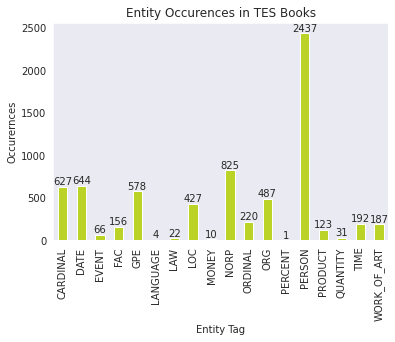

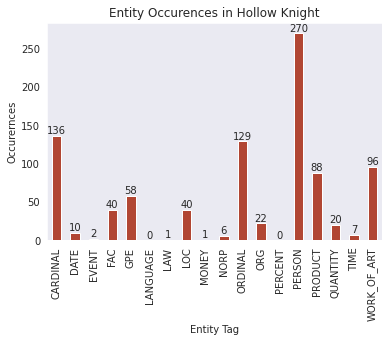

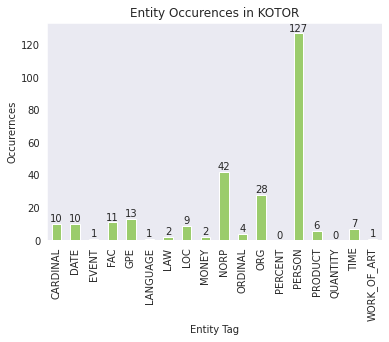

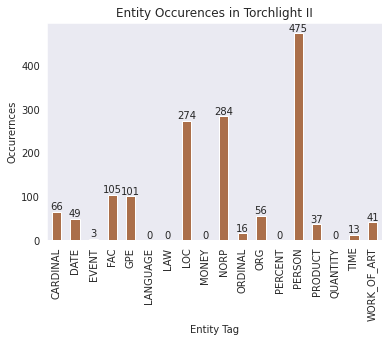

In [45]:
# Now let's actually graph it!
# Graph for all games
for game in names:
    ax = entities_info.unstack().plot.bar(stacked=True, y=game, xlabel='Entity Tag', ylabel='Occurernces'
                                        , legend=False, title='Entity Occurences in ' + game, color=np.random.rand(3), rot=90)
    plt.bar_label(ax.containers[0])

These aren't the prettiest, but they do accurately highlight the proportion of named entity types per video game. The most common named entity, by far, seems to be `PERSON` for all games, followed by `NORP` in most cases.

**NOTE:** When I used the `en_core_web_sm` model, the most popular tag was an unrivaled `ORG` for all games, followed by `PERSON`. An interesting change and I believe this to be more accurate.
***
## Hapaxes
This is a relatively simple task, let's get straight to it!

In [46]:
# Let's take our entity dataframe and filter for hapaxes by series
# Pretty ugly, but I couldn't think of a better way :\
hapaxes_tes = entities_df[entities_df['source'] == 'TES Books'].entity.value_counts()
hapaxes_tes = hapaxes_tes[hapaxes_tes == 1]
display(hapaxes_tes.sample(10))

# Extra filtering in Hollowknight due to tagging issues
# HOLLOW KNIGHT SEEMS TO CONTAIN NO HAPAXES!!!
"""hapaxes_hk = entities_df[~entities_df['entity'].str.contains('<', regex=False) & entities_df['source'] == 'Hollow Knight'].entity.value_counts()
hapaxes_hk = hapaxes_hk[hapaxes_hk == 1]
display(hapaxes_hk.sample())"""

hapaxes_hk = pd.Series()

hapaxes_tl = entities_df[entities_df['source'] == 'Torchlight II'].entity.value_counts()
hapaxes_tl = hapaxes_tl[hapaxes_tl == 1]
display(hapaxes_tl.sample(10))

hapaxes_ktr = entities_df[entities_df['source'] == 'KOTOR'].entity.value_counts()
hapaxes_ktr = hapaxes_ktr[hapaxes_ktr == 1]
display(hapaxes_ktr.sample(10))

hapaxes = [hapaxes_tes, hapaxes_hk, hapaxes_tl, hapaxes_ktr]

Day Twelve            1
Journal Vol.          1
you!Wylandriah        1
RecordsKarpu-sa       1
the "Unbroken Home    1
March                 1
Aumriel               1
Mistral Moon Sugar    1
Dumac Dwarfking       1
the Niben Valley      1
Name: entity, dtype: int64

/tmp/ipykernel_38552/1909425776.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hapaxes_hk = pd.Series()


RiftkeepStop                1
thousands of years          1
Taldimut                    1
yet?Zeryphesh               1
Fuchs                       1
Vanquisher Corps            1
the Guardian of Air.-       1
Ezrohir?If                  1
the Warbeast Den            1
the Mask of the Murderer    1
Name: entity, dtype: int64

Shasa                      1
Ahto City.[Success         1
Exchange                   1
Code                       1
Iziz                       1
second                     1
Pazaak                     1
Tar'eelok                  1
Ithorak                    1
Sasha na Manlorey!!This    1
Name: entity, dtype: int64

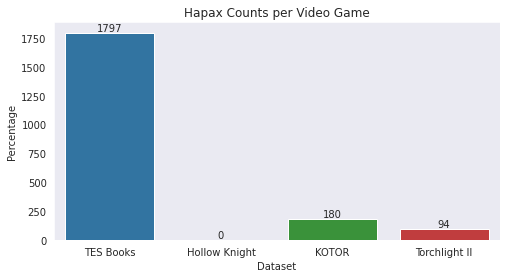

In [47]:
plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=[len(series) for series in hapaxes], title='Hapax Counts per Video Game', xlabel="Dataset", ylabel="Percentage")
plt.show()

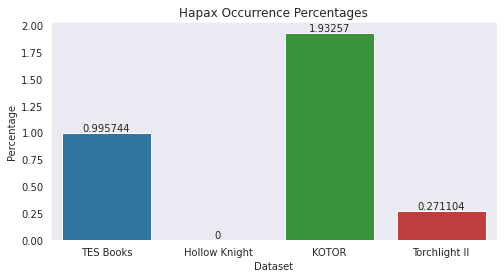

In [48]:
plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=[len(series)/len(docs[ind]) * 100 for (ind, series) in enumerate(hapaxes)]
        , title='Hapax Occurrence Percentages', xlabel="Dataset", ylabel="Percentage")
plt.show()